# Rasterize ICESat-2

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from shapely import wkt
from tqdm.auto import tqdm
import pyproj
import rasterio as rio

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_4512/3698703248.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# -----Define path to data and path for outputs
data_path = '/Users/raineyaberle/Research/PhD/Hubbard/surface_elevation'
out_path = os.path.join(data_path, 'coregistered')

# -----Load IFSAR
ifsar_fn = os.path.join(data_path, 'ifsar_hubbardDEM.tif')
ifsar = rxr.open_rasterio(ifsar_fn)

# -----Grab ICESat-2 file names
is2_path = os.path.join(data_path, 'ICESat-2')
is2_fns = sorted(glob.glob(os.path.join(is2_path, '*.csv')))
# remove the full CSV
is2_fns = [x for x in is2_fns if '2018_2023' not in x]
[os.path.basename(x) for x in is2_fns]

['ICESat-2_ATL06_Hubbard_2018-10-14.csv',
 'ICESat-2_ATL06_Hubbard_2018-11-10.csv',
 'ICESat-2_ATL06_Hubbard_2018-11-12.csv',
 'ICESat-2_ATL06_Hubbard_2018-12-05.csv',
 'ICESat-2_ATL06_Hubbard_2019-01-05.csv',
 'ICESat-2_ATL06_Hubbard_2019-01-07.csv',
 'ICESat-2_ATL06_Hubbard_2019-01-11.csv',
 'ICESat-2_ATL06_Hubbard_2019-02-05.csv',
 'ICESat-2_ATL06_Hubbard_2019-02-07.csv',
 'ICESat-2_ATL06_Hubbard_2019-02-09.csv',
 'ICESat-2_ATL06_Hubbard_2019-02-11.csv',
 'ICESat-2_ATL06_Hubbard_2019-06-07.csv',
 'ICESat-2_ATL06_Hubbard_2019-07-12.csv',
 'ICESat-2_ATL06_Hubbard_2019-08-07.csv',
 'ICESat-2_ATL06_Hubbard_2019-10-04.csv',
 'ICESat-2_ATL06_Hubbard_2019-10-07.csv',
 'ICESat-2_ATL06_Hubbard_2019-10-08.csv',
 'ICESat-2_ATL06_Hubbard_2019-11-05.csv',
 'ICESat-2_ATL06_Hubbard_2019-12-04.csv',
 'ICESat-2_ATL06_Hubbard_2019-12-05.csv',
 'ICESat-2_ATL06_Hubbard_2019-12-09.csv',
 'ICESat-2_ATL06_Hubbard_2019-12-13.csv',
 'ICESat-2_ATL06_Hubbard_2020-01-03.csv',
 'ICESat-2_ATL06_Hubbard_2020-01-0

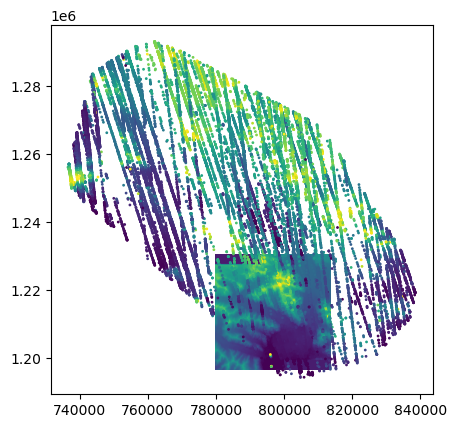

In [3]:
fig, ax = plt.subplots()
ax.imshow(ifsar.data[0], 
          extent=(np.min(ifsar.x.data), np.max(ifsar.x.data), 
                  np.min(ifsar.y.data), np.max(ifsar.y.data)))

for fn in is2_fns:
    is2_df = pd.read_csv(fn)
    # interpret geometry column
    is2_df['geometry'] = is2_df['geometry'].apply(wkt.loads)
    # convert to GeoDataFrame
    is2_gdf = gpd.GeoDataFrame(is2_df, geometry='geometry', crs='EPSG:4326')
    # reproject to IFSAR CRS
    is2_gdf = is2_gdf.to_crs(ifsar.rio.crs)
    # plot
    is2_gdf.plot(ax=ax, markersize=1, column='h_mean')
plt.show()

  0%|          | 0/67 [00:00<?, ?it/s]


2018-10-14
No data coverage over the image, skipping...

2018-11-10
No data coverage over the image, skipping...

2018-11-12
No data coverage over the image, skipping...

2018-12-05
No data coverage over the image, skipping...

2019-01-05
No data coverage over the image, skipping...

2019-01-07


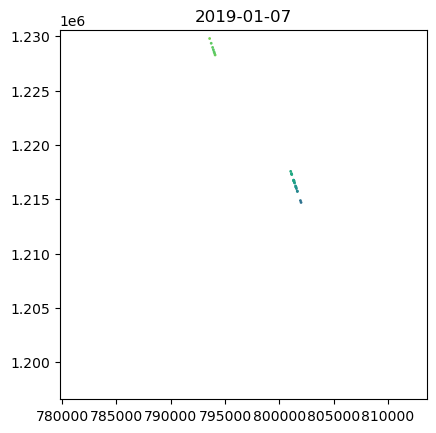

/Users/raineyaberle/Research/PhD/Hubbard/surface_elevation/coregistered/ICESat-2_ATL06_Hubbard_2019-01-07.tif

2019-01-11
No data coverage over the image, skipping...

2019-02-05
No data coverage over the image, skipping...

2019-02-07


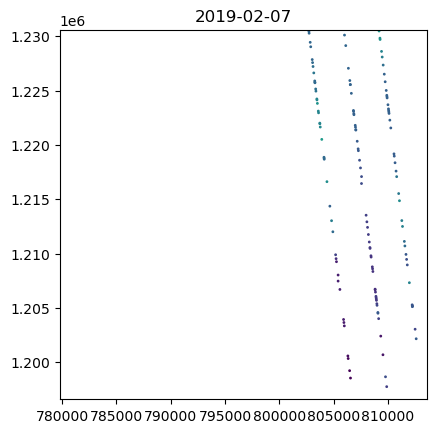

/Users/raineyaberle/Research/PhD/Hubbard/surface_elevation/coregistered/ICESat-2_ATL06_Hubbard_2019-02-07.tif

2019-02-09
No data coverage over the image, skipping...

2019-02-11
No data coverage over the image, skipping...

2019-06-07
No data coverage over the image, skipping...

2019-07-12
No data coverage over the image, skipping...

2019-08-07



KeyboardInterrupt



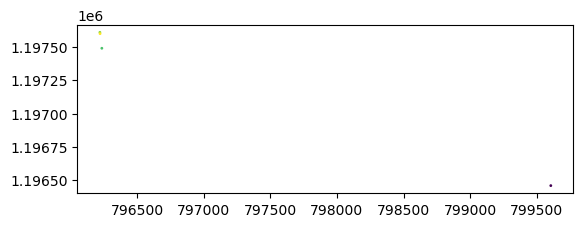

In [4]:
# -----Iterate over ICESat-2 files
for fn in tqdm(is2_fns):
    # grab date from file name
    date = os.path.basename(fn).split('Hubbard_')[1].split('.csv')[0]
    print('\n' + date)
    # load CSV using pandas
    is2_df = pd.read_csv(fn)
    # interpret geometry column
    is2_df['geometry'] = is2_df['geometry'].apply(wkt.loads)
    # convert to GeoDataFrame
    is2_gdf = gpd.GeoDataFrame(is2_df, geometry='geometry', crs='EPSG:4326')
    # reproject to Alaska Albers
    is2_gdf = is2_gdf.to_crs(ifsar.rio.crs)
    # create tuples of geometry, h_mean pairs
    geom_values = list(zip(is2_gdf['geometry'].values, is2_gdf['h_mean'].values))
    # rasterize GeoDataFrame to the IFSAR shape
    array = rio.features.rasterize(geom_values, 
                                   out_shape=ifsar.shape[1:], 
                                   transform=ifsar.rio.transform(),
                                   all_touched=True,
                                   fill=-9999)
    # check for any data coverage
    if (array==-9999).all():
        print('No data coverage over the image, skipping...')
        continue
    
    # convert array to xarray.Dataset
    is2_xr = xr.Dataset(data_vars=dict(h_mean=(["y", "x"], array)), 
                        coords=dict(
                            x=ifsar.x,
                            y=ifsar.y)
                       )

    # plot
    fig, ax = plt.subplots()
    is2_gdf.plot(ax=ax, column='h_mean', markersize=1)
    # ax.imshow(ifsar.data[0], cmap='Greys',
    #           extent=(np.min(ifsar.x.data), np.max(ifsar.x.data), 
    #                   np.min(ifsar.y.data), np.max(ifsar.y.data)))
    is2_xr = xr.where(is2_xr==-9999, np.nan, is2_xr)
    ax.imshow(is2_xr.h_mean.data, cmap='terrain', 
              extent=(np.min(is2_xr.x.data), np.max(is2_xr.x.data), 
                      np.min(is2_xr.y.data), np.max(is2_xr.y.data)))
    ax.set_title(date)
    plt.show()
    # save to file
    out_fn = os.path.join(out_path, os.path.basename(fn)[:-4] + '.tif')
    print(out_fn)


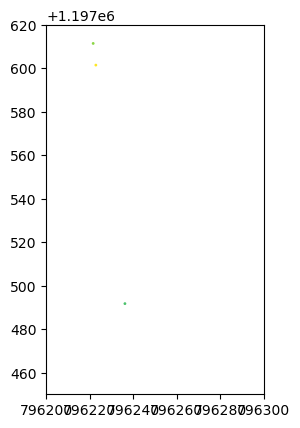

In [13]:
ax.set_xlim(796200, 796300)
ax.set_ylim(1.19745e6, 1.19762e6)
fig

In [10]:
ax.get_xlim()

(796052.3768492598, 799773.9382119545)